In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from io import BytesIO
import matplotlib.pyplot as plt
from custom_transformers import import_data, DropNullData, DropDuplicates
from text_utils import re_breakline, re_dates, re_hiperlinks, re_money, re_negation, re_numbers, re_special_chars, re_whitespaces, ApplyRegex, StemmingProcess, StopWordsRemoval
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from joblib import dump, load
from sklearn.linear_model import LogisticRegression
from ml_utils import ColumnMapping, BinaryClassifiersAnalysis, cross_val_performance
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, roc_curve
from text_utils import sentiment_analysis, stopwords_removal, stemming_process, ngrams_count
from viz_utils import single_countplot, donut_plot, format_spines

In [2]:
# Variables for address paths
DATA_PATH = '../Data_analysis/datasets'
PIPELINES_PATH = '/NLP/pipelines' # Take a look at your project structure
#PIPELINES_PATH = ''
MODELS_PATH = '/NLP/models' # Take a look at your project structure
#MODELS_PATH = ''

# Variables for reading the data
FILENAME = 'order_reviews.csv'
COLS_READ = ['review_comment_message', 'review_score']
CORPUS_COL = 'review_comment_message'
TARGET_COL = 'target'


# Defining stopwords
PT_STOPWORDS = stopwords.words('portuguese')

# Variables for saving data
#METRICS_FILEPATH = '/metrics/model_performance.csv' # Take a look at your project structure
# METRICS_FILEPATH = 'NLP\metrics\model_performance.csv'

# Variables for retrieving model
# MODEL_KEY = 'LogisticRegression'

In [3]:
# READING DATA

df = import_data('../Data_analysis/datasets/external_data.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)
df.rename(columns= {'comment':'review_comment_message', 'score':'review_score'}, inplace=True)
print('Dataset Shape: ', df.shape)
df.head()

This dataset has 3 columns, which 2 is/are applicable to optimization.

----------------------------------------------------
Memory usage (50 lines): 0.0013 MB
Memory usage after optimization (50 lines): 0.0009 MB
----------------------------------------------------

Reduction of 30.12% on memory usage

Dataset Shape:  (61572, 2)


,review_score,review_comment_message
0,5,"Coloquei em uma caixa bob, esta me atendendo 1..."
1,5,Gostei fácil instalação. No começo não funcion...
2,1,Péssimo. Não chega a 15 metros de distância e ...
3,5,Produto show de bola por enquanto. Não posso o...
4,5,Muito bom eselente acabamento amei gostei muit...


In [5]:
df.dropna(inplace=True)

In [6]:
# Creating a list of comment reviews
reviews = list(df['review_comment_message'].values)

reviews_breakline = re_breakline(reviews)
df['re_breakline'] = reviews_breakline
# Verifying results
#print_step_result(reviews, reviews_breakline, idx_list=[48])

reviews_hiperlinks = re_hiperlinks(reviews_breakline)
df['re_hiperlinks'] = reviews_hiperlinks
#print_step_result(reviews_breakline, reviews_hiperlinks, idx_list=[10607])

reviews_dates = re_dates(reviews_hiperlinks)
df['re_dates'] = reviews_dates
# Verifying results
#print_step_result(reviews_hiperlinks, reviews_dates, idx_list=[26161, 40729, 40901])

reviews_money = re_money(reviews_dates)
df['re_money'] = reviews_money
# Verifying results
#print_step_result(reviews_dates, reviews_money, idx_list=[25533, 32667, 32370])

reviews_numbers = re_numbers(reviews_money)
df['re_numbers'] = reviews_numbers
# Verifying results
#print_step_result(reviews_money, reviews_numbers, idx_list=[68])

reviews_negation = re_negation(reviews_numbers)
df['re_negation'] = reviews_negation
# Verifying results
#print_step_result(reviews_numbers, reviews_negation, idx_list=[4703, 4549, 4773, 4820])

reviews_special_chars = re_special_chars(reviews_negation)
df['re_special_chars'] = reviews_special_chars
# Verifying results
#print_step_result(reviews_negation, reviews_special_chars, idx_list=[45, 1165, 17579])

reviews_whitespaces = re_whitespaces(reviews_special_chars)
df['re_whitespaces'] = reviews_whitespaces
# Verifying results
#print_step_result(reviews_special_chars, reviews_whitespaces, idx_list=[66, 121, 5602])

reviews_stopwords = [' '.join(stopwords_removal(review)) for review in reviews_whitespaces]
df['stopwords_removed'] = reviews_stopwords
# Verifying results
#print_step_result(reviews_whitespaces, reviews_stopwords, idx_list=[108, 13646, 6563])

reviews_stemmer = [' '.join(stemming_process(review)) for review in reviews_stopwords]
df['stemming'] = reviews_stemmer
# Verifying results
#print_step_result(reviews_stopwords, reviews_stemmer, idx_list=[0, 45, -1])


### Labelling Data

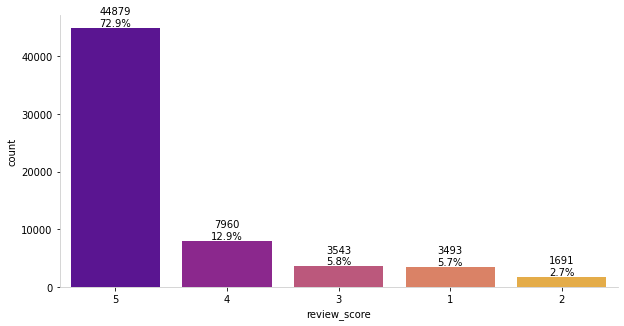

In [7]:
g, ax = plt.subplots(figsize=(10, 5))
single_countplot(x='review_score', df=df, ax=ax)

In [8]:
score_map = {
    1: 'negative',
    2: 'negative',
    3: 'positive',
    4: 'positive',
    5: 'positive'
}

df['sentiment_label'] = df['review_score'].map(score_map)

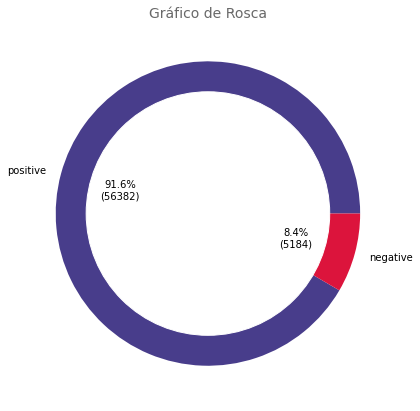

In [9]:

# Verifying results
fig, ax = plt.subplots(figsize=(7, 7))
donut_plot(df.query('sentiment_label in ("positive", "negative")'), 'sentiment_label', 
           label_names=df.query('sentiment_label in ("positive", "negative")')['sentiment_label'].value_counts().index,
           ax=ax, colors=['darkslateblue', 'crimson'])

### N-gram Viz

In [10]:
# Splitting the corpus into positive and negative comments
positive_comments = df.query('sentiment_label == "positive"')['stemming']
negative_comments = df.query('sentiment_label == "negative"')['stemming']

# Extracting the top 10 unigrams by sentiment
unigrams_pos = ngrams_count(positive_comments, (1, 1), 10)
unigrams_neg = ngrams_count(negative_comments, (1, 1), 10)

# Extracting the top 10 unigrams by sentiment
bigrams_pos = ngrams_count(positive_comments, (2, 2), 10)
bigrams_neg = ngrams_count(negative_comments, (2, 2), 10)

# Extracting the top 10 unigrams by sentiment
trigrams_pos = ngrams_count(positive_comments, (3, 3), 10)
trigrams_neg = ngrams_count(negative_comments, (3, 3), 10)

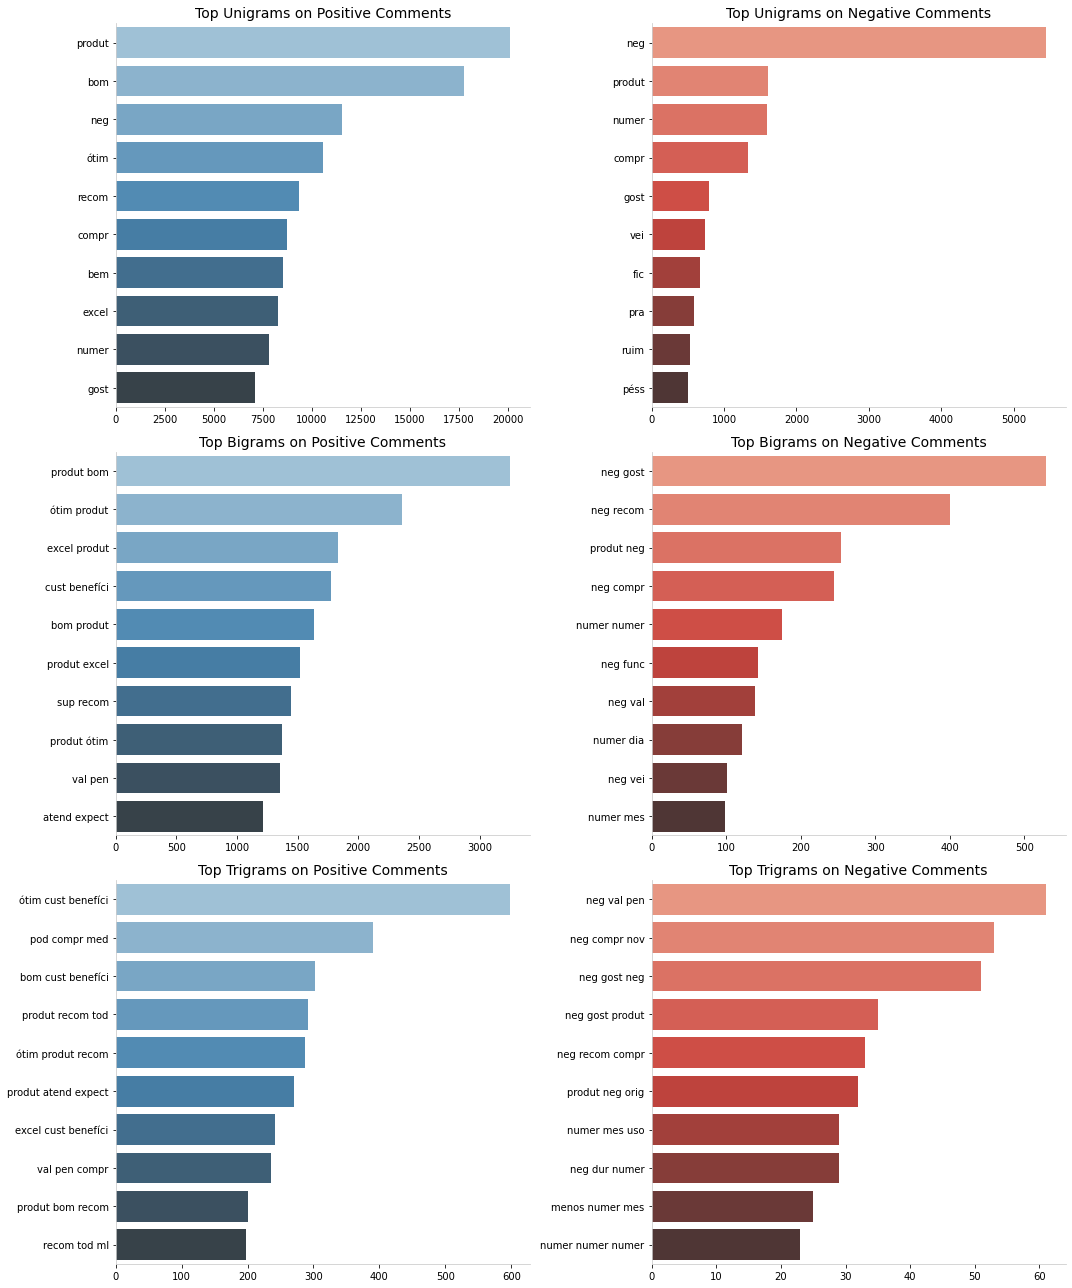

In [11]:
# Joining everything in a python dictionary to make the plots easier
ngram_dict_plot = {
    'Top Unigrams on Positive Comments': unigrams_pos,
    'Top Unigrams on Negative Comments': unigrams_neg,
    'Top Bigrams on Positive Comments': bigrams_pos,
    'Top Bigrams on Negative Comments': bigrams_neg,
    'Top Trigrams on Positive Comments': trigrams_pos,
    'Top Trigrams on Negative Comments': trigrams_neg,
}

# Plotting the ngrams analysis
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 18))
i, j = 0, 0
colors = ['Blues_d', 'Reds_d']
for title, ngram_data in ngram_dict_plot.items():
    ax = axs[i, j]
    sns.barplot(x='count', y='ngram', data=ngram_data, ax=ax, palette=colors[j])
    
    # Customizing plots
    format_spines(ax, right_border=False)
    ax.set_title(title, size=14)
    ax.set_ylabel('')
    ax.set_xlabel('')
    
    # Incrementing the index
    j += 1
    if j == 2:
        j = 0
        i += 1
plt.tight_layout()
plt.show()

### NLP

In [12]:
df_ml = import_data('../Data_analysis/datasets/external_data.csv')
df_ml.drop('Unnamed: 0', axis=1, inplace=True)
df_ml.rename(columns= {'comment':'review_comment_message', 'score':'review_score'}, inplace=True)
print('Dataset Shape: ', df_ml.shape)

This dataset has 3 columns, which 2 is/are applicable to optimization.

----------------------------------------------------
Memory usage (50 lines): 0.0013 MB
Memory usage after optimization (50 lines): 0.0009 MB
----------------------------------------------------

Reduction of 30.12% on memory usage

Dataset Shape:  (61572, 2)


In [4]:
# Creating a pipeline for the initial prep on the data

score_map = {
    1: 0,
    2: 0,
    3: 0,
    4: 1,
    5: 1
}

initial_prep_pipeline = Pipeline([
    ('mapper', ColumnMapping(old_col_name='review_score', mapping_dict=score_map, new_col_name=TARGET_COL)),
    ('null_dropper', DropNullData()),
    ('dup_dropper', DropDuplicates())
])

# Applying initial prep pipeline
df_prep = initial_prep_pipeline.fit_transform(df_ml)

In [5]:
df_prep.reset_index(inplace=True)
df_prep.drop('index', axis=1, inplace=True)

In [6]:
# Defining regex transformers to be applied
regex_transformers = {
    'break_line': re_breakline,
    'hiperlinks': re_hiperlinks,
    'dates': re_dates,
    'money': re_money,
    'numbers': re_numbers,
    'negation': re_negation,
    'special_chars': re_special_chars,
    'whitespaces': re_whitespaces
}

In [22]:
# Building a text prep pipeline
text_prep_pipeline = Pipeline([
    ('regex', ApplyRegex(regex_transformers)),
    ('stopwords', StopWordsRemoval(PT_STOPWORDS)),
    ('stemming', StemmingProcess(RSLPStemmer())),
    ('vectorizer', TfidfVectorizer(max_features=300, min_df=1, max_df=2, stop_words=PT_STOPWORDS))
])


In [8]:
model_path = os.environ.get('MODEL_PATH', 'models/sentiment_clf_model.pkl')
with open(model_path, 'rb') as pipe_file:
    model = load(BytesIO(pipe_file.read()))

In [9]:
#comment = [df_prep['review_comment_message'][31]]
comment = ['feio e de baixa qualidade']


In [23]:
comment_prep = text_prep_pipeline.fit_transform(comment)
comment_prep.data

array([0.70710678, 0.70710678])

In [11]:
from scipy.sparse import csr_matrix

In [24]:
m_array = csr_matrix(comment_prep, shape=(1,500)).toarray()
model.predict(m_array)[0]

0

In [26]:
sent_anls = []
for i in range(len(df_prep)):
    try:
        comment_prep = text_prep_pipeline.fit_transform([df_prep['review_comment_message'][i]])
        m_array = csr_matrix(comment_prep, shape=(1,500)).toarray()
        sent_anls. append(model.predict(m_array)[0])
    except Exception as e:
        print(f"key {i}: error {e}")

# sent_anls

key 9211: error empty vocabulary; perhaps the documents only contain stop words
key 18468: error empty vocabulary; perhaps the documents only contain stop words
key 19897: error empty vocabulary; perhaps the documents only contain stop words
key 21869: error empty vocabulary; perhaps the documents only contain stop words
key 24323: error empty vocabulary; perhaps the documents only contain stop words
key 25455: error empty vocabulary; perhaps the documents only contain stop words
key 31336: error empty vocabulary; perhaps the documents only contain stop words
key 34361: error empty vocabulary; perhaps the documents only contain stop words
key 38143: error empty vocabulary; perhaps the documents only contain stop words
key 46718: error empty vocabulary; perhaps the documents only contain stop words


In [64]:
sent_dict = {
    'sentiment': sent_anls,
    'sentiment_label': [('positive' if x ==1 else "negative") for x in sent_anls]
}

In [65]:
sent_df = pd.DataFrame(sent_dict)
# sent_df
# Groove is in The Heart
# Dee Lite

In [66]:
sent_df.query('sentiment_label in ("positive", "negative")')

,sentiment,sentiment_label
0,1,positive
1,0,negative
2,1,positive
3,1,positive
4,1,positive
...,...,...
56260,0,negative
56261,0,negative
56262,0,negative
56263,0,negative


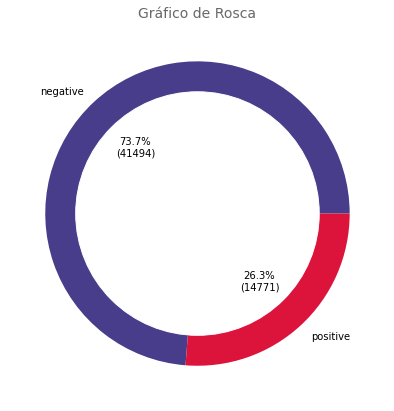

In [67]:
fig, ax = plt.subplots(figsize=(7, 7))
donut_plot(sent_df.query('sentiment_label in ("positive", "negative")'), 'sentiment_label', 
           label_names=sent_df.query('sentiment_label in ("positive", "negative")')['sentiment_label'].value_counts().index,
           ax=ax, colors=['darkslateblue', 'crimson'])

###  Category Analysis

In [68]:
import glob

In [75]:
extension = 'csv'
files = [i for i in glob.glob('../Scraping/External_data/*.{}'.format(extension))]

In [84]:
def read_prep_data(path):
    
    df = import_data(path)
    df.drop('Unnamed: 0', axis=1, inplace=True)
    df.rename(columns= {'comment':'review_comment_message', 'score':'review_score'}, inplace=True)    
    df_prep = initial_prep_pipeline.fit_transform(df)
    df_prep.reset_index(inplace=True)
    df_prep.drop('index', axis=1, inplace=True)

    return df_prep

In [80]:
def nlp_predic(data):
    sent_anls = []
    for i in range(len(data)):
        try:
            comment_prep = text_prep_pipeline.fit_transform([data['review_comment_message'][i]])
            m_array = csr_matrix(comment_prep, shape=(1,500)).toarray()
            sent_anls. append(model.predict(m_array)[0])
        except Exception as e:
            pass

    sent_dict = {
    'sentiment': sent_anls,
    'sentiment_label': [('positive' if x ==1 else "negative") for x in sent_anls]
}
    
    return pd.DataFrame(sent_dict)

This dataset has 3 columns, which 2 is/are applicable to optimization.

----------------------------------------------------
Memory usage (50 lines): 0.0013 MB
Memory usage after optimization (50 lines): 0.0009 MB
----------------------------------------------------

Reduction of 30.12% on memory usage



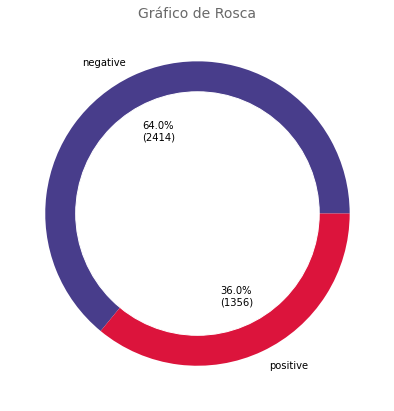

This dataset has 3 columns, which 2 is/are applicable to optimization.

----------------------------------------------------
Memory usage (50 lines): 0.0013 MB
Memory usage after optimization (50 lines): 0.0009 MB
----------------------------------------------------

Reduction of 30.12% on memory usage



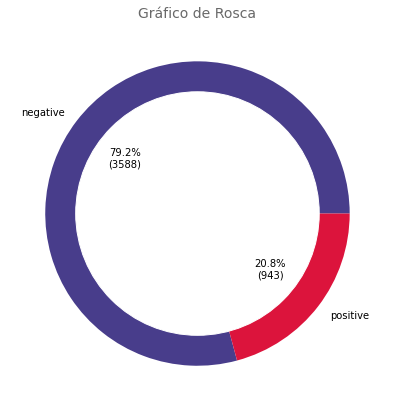

This dataset has 3 columns, which 2 is/are applicable to optimization.

----------------------------------------------------
Memory usage (50 lines): 0.0013 MB
Memory usage after optimization (50 lines): 0.0009 MB
----------------------------------------------------

Reduction of 30.12% on memory usage



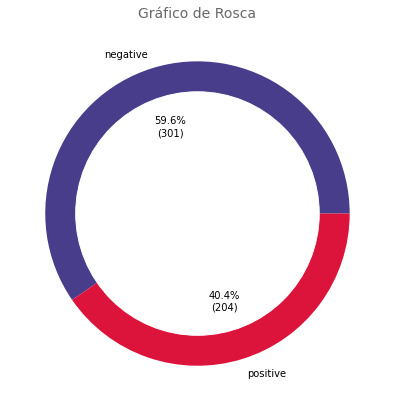

This dataset has 3 columns, which 2 is/are applicable to optimization.

----------------------------------------------------
Memory usage (50 lines): 0.0013 MB
Memory usage after optimization (50 lines): 0.0009 MB
----------------------------------------------------

Reduction of 30.12% on memory usage



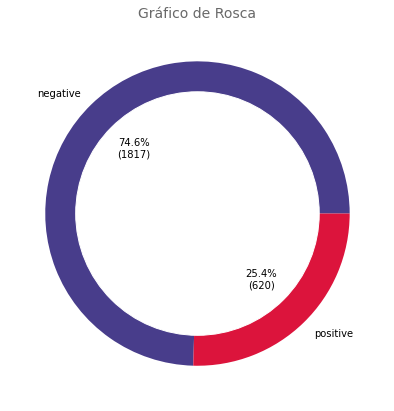

This dataset has 3 columns, which 2 is/are applicable to optimization.

----------------------------------------------------
Memory usage (50 lines): 0.0013 MB
Memory usage after optimization (50 lines): 0.0009 MB
----------------------------------------------------

Reduction of 30.12% on memory usage



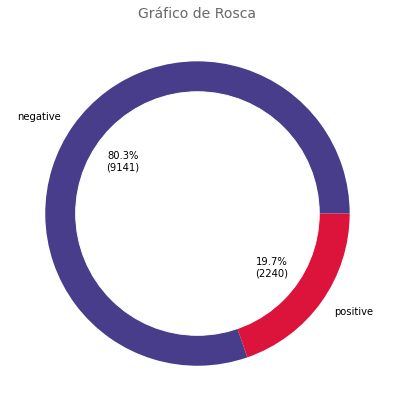

This dataset has 3 columns, which 2 is/are applicable to optimization.

----------------------------------------------------
Memory usage (50 lines): 0.0013 MB
Memory usage after optimization (50 lines): 0.0009 MB
----------------------------------------------------

Reduction of 30.12% on memory usage



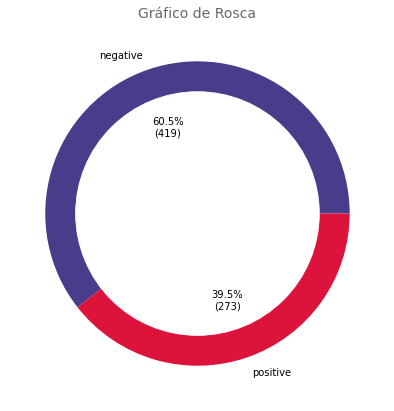

This dataset has 3 columns, which 2 is/are applicable to optimization.

----------------------------------------------------
Memory usage (50 lines): 0.0013 MB
Memory usage after optimization (50 lines): 0.0009 MB
----------------------------------------------------

Reduction of 30.12% on memory usage



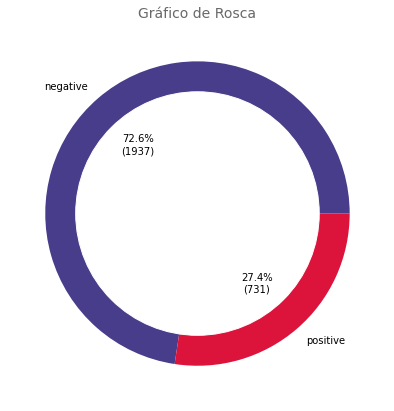

This dataset has 3 columns, which 2 is/are applicable to optimization.

----------------------------------------------------
Memory usage (50 lines): 0.0013 MB
Memory usage after optimization (50 lines): 0.0009 MB
----------------------------------------------------

Reduction of 30.12% on memory usage



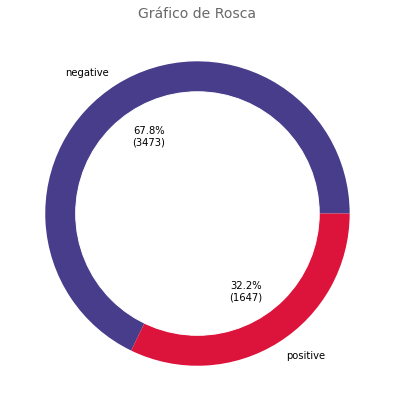

This dataset has 3 columns, which 2 is/are applicable to optimization.

----------------------------------------------------
Memory usage (50 lines): 0.0013 MB
Memory usage after optimization (50 lines): 0.0009 MB
----------------------------------------------------

Reduction of 30.12% on memory usage



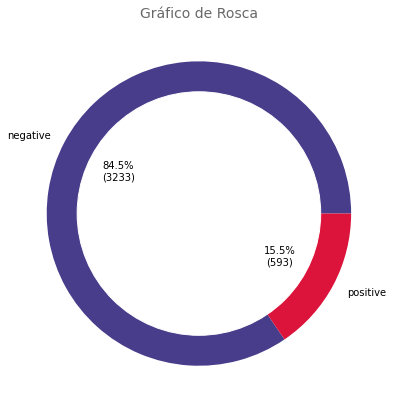

This dataset has 3 columns, which 2 is/are applicable to optimization.

----------------------------------------------------
Memory usage (50 lines): 0.0013 MB
Memory usage after optimization (50 lines): 0.0009 MB
----------------------------------------------------

Reduction of 30.12% on memory usage



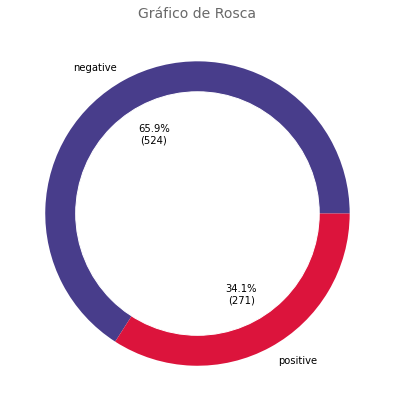

This dataset has 3 columns, which 2 is/are applicable to optimization.

----------------------------------------------------
Memory usage (50 lines): 0.0013 MB
Memory usage after optimization (50 lines): 0.0009 MB
----------------------------------------------------

Reduction of 30.12% on memory usage



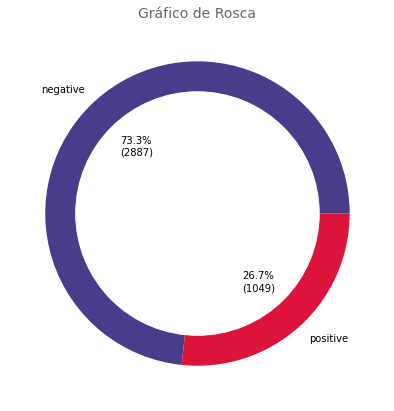

This dataset has 3 columns, which 2 is/are applicable to optimization.

----------------------------------------------------
Memory usage (50 lines): 0.0013 MB
Memory usage after optimization (50 lines): 0.0009 MB
----------------------------------------------------

Reduction of 30.12% on memory usage



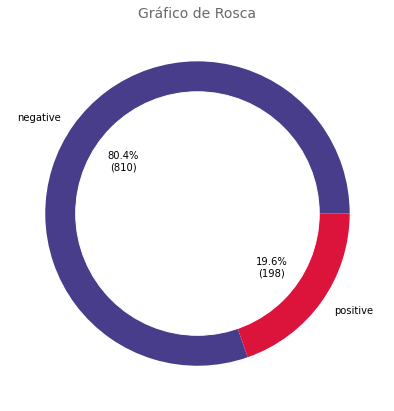

This dataset has 3 columns, which 2 is/are applicable to optimization.

----------------------------------------------------
Memory usage (50 lines): 0.0013 MB
Memory usage after optimization (50 lines): 0.0009 MB
----------------------------------------------------

Reduction of 30.12% on memory usage



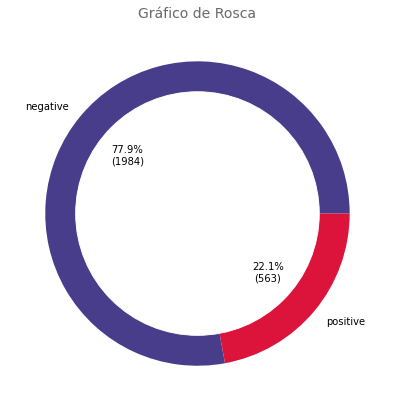

This dataset has 3 columns, which 2 is/are applicable to optimization.

----------------------------------------------------
Memory usage (50 lines): 0.0013 MB
Memory usage after optimization (50 lines): 0.0009 MB
----------------------------------------------------

Reduction of 30.12% on memory usage



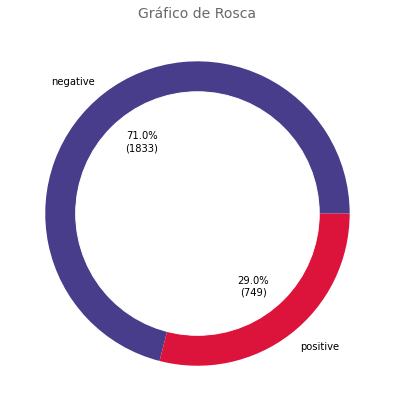

This dataset has 3 columns, which 2 is/are applicable to optimization.

----------------------------------------------------
Memory usage (50 lines): 0.0013 MB
Memory usage after optimization (50 lines): 0.0009 MB
----------------------------------------------------

Reduction of 30.12% on memory usage



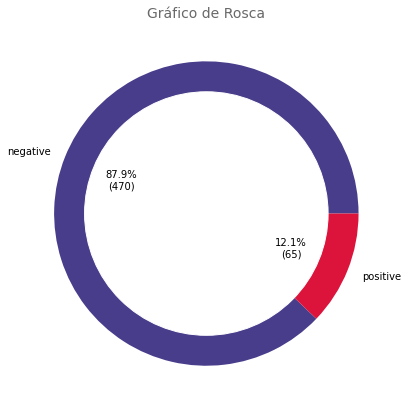

This dataset has 3 columns, which 2 is/are applicable to optimization.

----------------------------------------------------
Memory usage (50 lines): 0.0013 MB
Memory usage after optimization (50 lines): 0.0009 MB
----------------------------------------------------

Reduction of 30.12% on memory usage



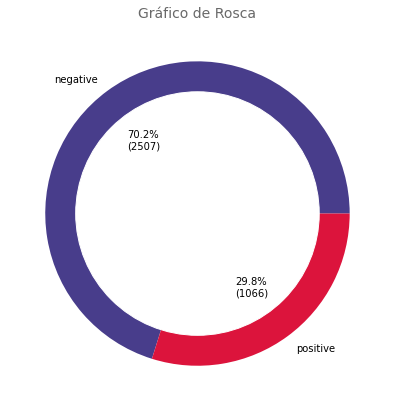

This dataset has 3 columns, which 2 is/are applicable to optimization.

----------------------------------------------------
Memory usage (50 lines): 0.0013 MB
Memory usage after optimization (50 lines): 0.0009 MB
----------------------------------------------------

Reduction of 30.12% on memory usage



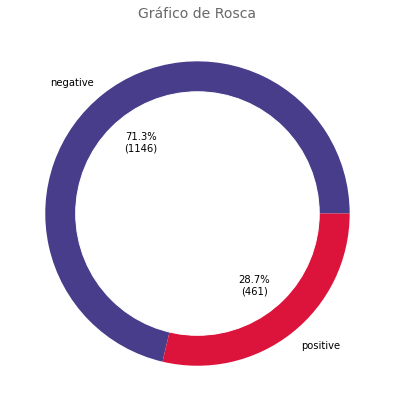

This dataset has 3 columns, which 2 is/are applicable to optimization.

----------------------------------------------------
Memory usage (50 lines): 0.0013 MB
Memory usage after optimization (50 lines): 0.0009 MB
----------------------------------------------------

Reduction of 30.12% on memory usage



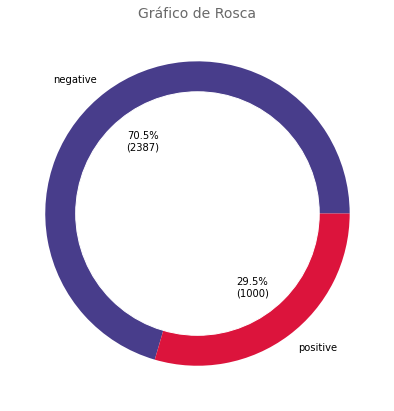

This dataset has 3 columns, which 2 is/are applicable to optimization.

----------------------------------------------------
Memory usage (50 lines): 0.0013 MB
Memory usage after optimization (50 lines): 0.0009 MB
----------------------------------------------------

Reduction of 30.12% on memory usage



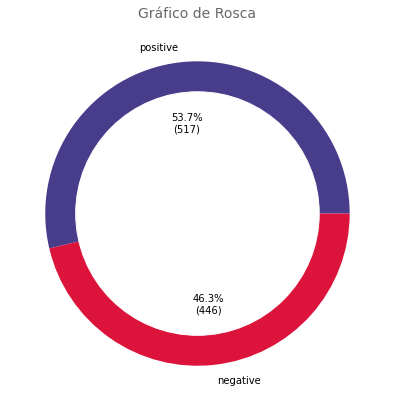

This dataset has 3 columns, which 2 is/are applicable to optimization.

----------------------------------------------------
Memory usage (50 lines): 0.0013 MB
Memory usage after optimization (50 lines): 0.0009 MB
----------------------------------------------------

Reduction of 30.12% on memory usage



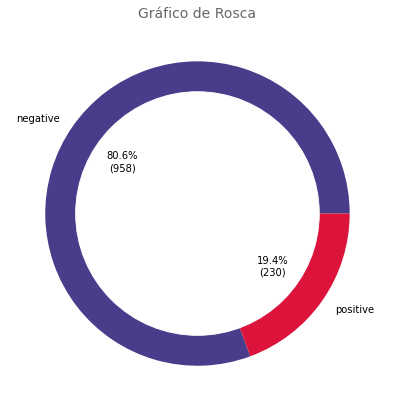

In [89]:
for file in files:
    data = read_prep_data(file)
    prediction = nlp_predic(data)

    fig, ax = plt.subplots(figsize=(7, 7))
    donut_plot(prediction.query('sentiment_label in ("positive", "negative")'), 'sentiment_label', 
            label_names=prediction.query('sentiment_label in ("positive", "negative")')['sentiment_label'].value_counts().index,
            ax=ax, colors=['darkslateblue', 'crimson'])
    plt.show()
